In [1]:
import os
from classification_models.tfkeras import Classifiers

ResNet34, preprocess_input = Classifiers.get('resnet34')

In [2]:
log_dir = "logs/"
os.makedirs(log_dir, exist_ok=True)

%reload_ext tensorboard
%tensorboard --logdir {log_dir} --reload_multifile True --host 0.0.0.0 --port 6006

Reusing TensorBoard on port 6006 (pid 111), started 0:17:09 ago. (Use '!kill 111' to kill it.)

In [3]:
# Run only for training!
import glob
import math
import datetime
import numpy as np
import tensorflow as tf

# Change parameters here...
data_dir = '../data/' # Change
sizex = 500
sizey = 500
sizez = 3
num_datasets = 5
batch_size = 32
nb_epochs = 50
validation_ratio = 0.3

In [4]:
# Collect all the .npz files
numpy_datasets = glob.glob(data_dir+'dataset*')

In [5]:
# METHOD 1: (first 4 files)
# load the data into numpy arrays from npz files:
#for dataset in numpy_datasets[:num_datasets]:
#    try:
#        with np.load(dataset) as data:
#            x_dust   = np.append( x_dust, data['x_dust'],axis=0)
#            x_nodust = np.append( x_nodust, data['x_nodust'],axis=0)
#            y        = np.append( y, data['y'],axis=0)
#            ids      = np.append( ids, data['id'],axis=0)
#    except:
#        with np.load(dataset) as data:
#            x_dust   = data['x_dust']
#            x_nodust = data['x_nodust']
#            y        = data['y']
#            ids      = data['id']

In [6]:
# METHOD 2: (first 4 files)
# load the data into a dictionary from npz files
data_dict = {}
for dataset in numpy_datasets[:num_datasets]:
    with np.load(dataset) as data:
        if 'x_dust' in data_dict.keys():
            data_dict['x_dust']   = np.append( data_dict['x_dust'], data['x_dust'],axis=0)
            data_dict['x_nodust'] = np.append( data_dict['x_nodust'], data['x_nodust'],axis=0)
            data_dict['y']        = np.append( data_dict['y'], data['y'],axis=0)
            data_dict['ids']      = np.append( data_dict['ids'], data['id'],axis=0)
        else:
            data_dict['x_dust']   = data['x_dust']
            data_dict['x_nodust'] = data['x_nodust']
            data_dict['y']        = data['y']
            data_dict['ids']      = data['id']

In [7]:
# check the sahpe of the array (100 images of 500x500x3 = 4 files of 25 images)
# x_dust.shape

In [8]:
# check the shape of the dictionary (100 images of 500x500x3 = 4 files of 25 images)
data_dict['x_dust'].shape

(125, 500, 500, 3)

In [9]:
# Normalice the angular momentum
from sklearn.preprocessing import normalize

# Compute the angles from the x,y,z labels
# theta = np.arctan(np.sqrt(x**2 + y**2)/z)
# phi = np.arctan(y/x)
def cart_to_esf(xyz):
    angles = np.empty( (len(xyz),2) )
    angles[:,0] = np.arctan2(np.sqrt(xyz[:,0]**2 + xyz[:,1]**2),xyz[:,2]) *180/np.pi #theta angle in degrees
    angles[:,1] = np.arctan2(xyz[:,1],xyz[:,0]) * 180/np.pi #phi angle in degrees
    return angles

# Define the function to go back to cartisian cordinates
def esf_to_cart(angles):
    xyz = np.empty( (len(angles),3) )
    ang_rad = angles*np.pi/180
    xyz[:,0] = np.sin(ang_rad[:,0])*np.cos(ang_rad[:,1])
    xyz[:,1] = np.sin(ang_rad[:,0])*np.sin(ang_rad[:,1])
    xyz[:,2] = np.cos(ang_rad[:,0])
    return xyz

#break the degeneracy of the solutions restricting the solution to 1 sector
def break_degeneracy(angles):
    ang_norm = angles
    for i in range(len(angles)):
        if ang_norm[:,1][i] < 0:
            ang_norm[:,1][i] = (ang_norm[:,1][i] + 180)
    return ang_norm

#map the solution to be between [0,1]
def map_to_1(angles, max = 180 ):
    ang_norm = angles/max
    return ang_norm

'''data_dict['y_norm'] = normalize(data_dict['y'], axis=1)
data_dict['y_angle'] = cart_to_esf(data_dict['y_norm'])
data_dict['y_ang'] = break_degeneracy(data_dict['y_angle'])
data_dict['y_ang_norm'] = map_to_1(data_dict['y_ang'])
data_dict['y_xyz_nd'] = esf_to_cart(data_dict['y_ang'])
data_dict['y_xyz']   = esf_to_cart(data_dict['y_angle'])'''

# computing the normaliced angle and the come back to cartesian to check the conversion
data_dict['y_angle'] = break_degeneracy(cart_to_esf(normalize(data_dict['y'], axis=1)))
data_dict['y_xyz_nd']= esf_to_cart(data_dict['y_angle'])
data_dict['y_angle'] = map_to_1(data_dict['y_angle'])

In [10]:
# check the shape of our dictionary
print(data_dict['y_angle'].shape)

(125, 2)


In [11]:
# separate in batches and shuffle the data with a fixed seed
#dataset = dataset.batch(batch_size)
#dataset = dataset.shuffle(10, seed=123)
AUTO = tf.data.experimental.AUTOTUNE

In [12]:
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# functions to visualice the data 
def viz(ds):
    elem = ds.take(3)
    for e in elem:
        img = e['x_nodust'][:, :,:]
        fig, ax = plt.subplots(figsize=(5,5))
        im = ax.imshow(img, cmap='gray', vmin=0, vmax=255,origin='lower')
        ax.arrow(250,250,100*e['y_xyz_nd'][0],100*e['y_xyz_nd'][1], head_width=7, head_length=10, fc='g', ec='g')
        #display(Markdown("#### **Label:** {}".format(e['y_norm'])))
        display(Markdown("#### **angle:** {}".format(e['y_angle'])))
        display(Markdown("#### **inverse:** {}".format(e['y_xyz_nd'])))
        print(e['ids'])
        plt.show()
        break

def viz_batch(ds, idx):
    elem = ds.take(1) # get first batch
    for e in elem:
        img = e['x_nodust'][idx, :, :,:]
        fig, ax = plt.subplots(figsize=(5,5))
        im = ax.imshow(img, cmap='gray', vmin=0, vmax=255, origin='lower')
        ax.arrow(250,250,100*e['y_xyz_nd'][0,0],100*e['y_xyz_nd'][0,1], head_width=7, head_length=10, fc='g', ec='g')
        #display(Markdown("#### **Label:** {}".format(e['y_norm'][idx])))
        display(Markdown("#### **angle:** {}".format(e['y_angle'][idx])))
        display(Markdown("#### **inverse:** {}".format(e['y_xyz_nd'][idx])))
        print(e['ids'][idx])
        plt.show()
        break
        
# create the dataset from the dictionary and see the size and type
dataset = tf.data.Dataset.from_tensor_slices(data_dict)
print(dataset)

<TensorSliceDataset shapes: {x_dust: (500, 500, 3), x_nodust: (500, 500, 3), y: (3,), ids: (), y_angle: (2,), y_xyz_nd: (3,)}, types: {x_dust: tf.float64, x_nodust: tf.float64, y: tf.float64, ids: tf.string, y_angle: tf.float64, y_xyz_nd: tf.float64}>


In [13]:
#import tensorflow probability
import tensorflow_probability as tfp

#### **angle:** [0.56040278 0.84607795]

#### **inverse:** [-0.86945268  0.45658841 -0.18862412]

tf.Tensor(b'g4.86e10_x302_y97_z327', shape=(), dtype=string)


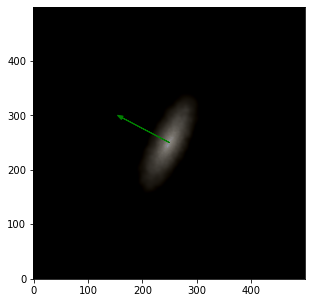

#### **angle:** [0.37129754 0.75471813]

#### **inverse:** [-0.65965402  0.64038289  0.39340353]

tf.Tensor(b'g6.77e10_x96_y353_z333', shape=(), dtype=string)


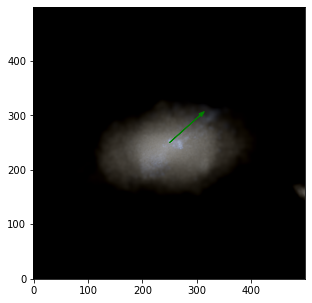

In [14]:
# visualice the data
viz(dataset)
real_dataset = dataset.batch(batch_size).shuffle(10, seed=321)
viz_batch(real_dataset, 2) # select any index within the batch, e.g. 2

In [15]:
# defining the train and validation dataset from the existing dictionary, shufling and batching
ds_size = len(data_dict['y_angle'])

input_ds = (
    tf.data.Dataset.from_tensor_slices((data_dict['x_nodust'].astype(np.float32), data_dict['y_angle'].astype(np.float32)))
                    # Use seed to ensure we always have the same validation data set!
                   .shuffle(ds_size, seed = 123, reshuffle_each_iteration = False)
)

val_size = math.floor(ds_size * validation_ratio)
validation_ds = ( input_ds.take(val_size).batch(batch_size) )
train_ds = ( input_ds.skip(val_size).shuffle(buffer_size=100, reshuffle_each_iteration=True).batch(batch_size) )

print(train_ds)
print(validation_ds)

<BatchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>


In [ ]:
# Build model
base_model = ResNet34(input_shape=(sizey,sizex,3), weights='imagenet', include_top=False)

# redefine the output to be from tensorflow probability a PDF
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tfp.layers.DenseReparameterization(2, activation='softmax')(x)
model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])

# Use existing best weights if available...
snapshot_weights = 'best_weights.hdf5'
if os.path.isfile(snapshot_weights):
    model.load_weights(snapshot_weights)


model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# For tensorboard
log_dir_s = log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir_s, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_s, histogram_freq=1, update_freq='batch', profile_batch=0)

# Checkpointing
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=snapshot_weights,
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True)

callbacks = [
    tensorboard_callback,
    checkpointer
]

model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = nb_epochs,
    callbacks = callbacks,)
    # class_weight=class_weight)

model.save('trained.h5') # Not really needed as we have the weights already

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 500, 500, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 500, 500, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 506, 506, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 250, 250, 64) 9408        zero_padding2d[0][0]             
___________________